In [13]:
!sudo apt -y install libportaudio2
!pip install tflite_model_maker

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import os
import glob
import random
import shutil

In [15]:
import librosa
import soundfile as sf
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
import tensorflow as tf

In [17]:
import tflite_model_maker as mm

In [18]:
from tflite_model_maker import audio_classifier

In [19]:
from tflite_model_maker.config import ExportFormat

In [20]:
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.8.0


In [21]:
print(f"Model Maker Version: {mm.__version__}")

Model Maker Version: 0.4.0


In [22]:
use_custom_dataset = True

In [23]:
if use_custom_dataset:
  # Specify the ZIP file you uploaded:
  !unzip dataset.zip
  # Specify the unzipped path to your custom dataset
  # (this path contains all the subfolders with classification names):
  dataset_dir = './dataset'

Archive:  dataset.zip
replace dataset/bird/00b01445_nohash_0.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace dataset/bird/00b01445_nohash_0.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [24]:
def move_background_dataset(dataset_dir):
  dest_dir = os.path.join(dataset_dir, 'background')
  if os.path.exists(dest_dir):
    files = glob.glob(os.path.join(background_dir, '*.wav'))
    for file in files:
      shutil.move(file, dest_dir)
  else:
    shutil.move(background_dir, dest_dir)

In [26]:
if use_custom_dataset:

  # Now we separate some of the files that we'll use for testing:
  test_dir = './dataset-test'
  test_data_ratio = 0.2
  dirs = glob.glob(os.path.join(dataset_dir, '*/'))
  for dir in dirs:
    files = glob.glob(os.path.join(dir, '*.wav'))
    test_count = round(len(files) * test_data_ratio)
    random.seed(42)
    random.shuffle(files)
    # Move test samples:
    for file in files[:test_count]:
      class_dir = os.path.basename(os.path.normpath(dir))
      os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
      os.rename(file, os.path.join(test_dir, class_dir, os.path.basename(file)))
    print('Moved', test_count, 'images from', class_dir)

Moved 30 images from bird
Moved 30 images from cat


In [27]:
def get_random_audio_file(samples_dir):
  files = os.path.abspath(os.path.join(samples_dir, '*/*.wav'))
  files_list = glob.glob(files)
  random_audio_path = random.choice(files_list)
  return random_audio_path

def show_sample(audio_path):
  audio_data, sample_rate = sf.read(audio_path)
  class_name = os.path.basename(os.path.dirname(audio_path))
  print(f'Class: {class_name}')
  print(f'File: {audio_path}')
  print(f'Sample rate: {sample_rate}')
  print(f'Sample length: {len(audio_data)}')

  plt.title(class_name)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

Class: cat
File: /content/dataset-test/cat/4abb2400_nohash_0.wav
Sample rate: 16000
Sample length: 16000


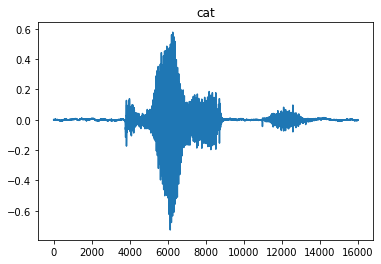

In [28]:
random_audio = get_random_audio_file(test_dir)
show_sample(random_audio)

In [29]:
spec = audio_classifier.BrowserFftSpec()

INFO:tensorflow:Checkpoints are stored in /tmp/tmpriesrkm4
32768/18467 [=====================================================] - 0s 0us/step
16384/203 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [30]:
if not use_custom_dataset:
  train_data_ratio = 0.8
  train_data = audio_classifier.DataLoader.from_folder(
      spec, dataset_dir, cache=True)
  train_data, validation_data = train_data.split(train_data_ratio)
  test_data = audio_classifier.DataLoader.from_folder(
      spec, test_dir, cache=True)

In [31]:
if use_custom_dataset:
  train_data_ratio = 0.8
  train_data = audio_classifier.DataLoader.from_folder(
      spec, dataset_dir, cache=True)
  train_data, validation_data = train_data.split(train_data_ratio)
  test_data = audio_classifier.DataLoader.from_folder(
      spec, test_dir, cache=True)

In [32]:
# If your dataset has fewer than 100 samples per class,
# you might want to try a smaller batch size
batch_size = 25
epochs = 25
model = audio_classifier.create(train_data, spec, validation_data, batch_size, epochs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 42, 225, 8)        136       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 112, 8)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 109, 32)       2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 51, 32)         8224      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 25, 32)       

In [33]:
model.evaluate(test_data)

2/2 [==============================] - 3s 1s/step - loss: 0.0045 - acc: 1.0000


[0.00445579644292593, 1.0]

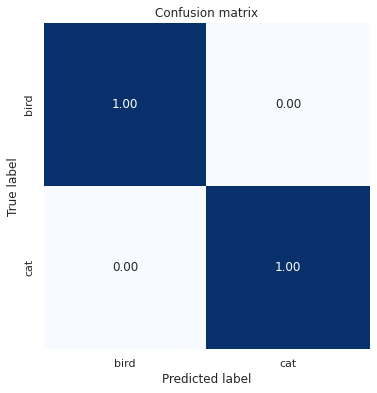

In [34]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  sns.set(rc = {'figure.figsize':(6,6)})
  sns.heatmap(
      confusion_normalized, xticklabels=test_labels, yticklabels=test_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True, cbar=False)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

In [35]:
TFLITE_FILENAME = 'browserfft-speech.tflite'
SAVE_PATH = './models'

In [36]:
print(f'Exporing the model to {SAVE_PATH}')
model.export(SAVE_PATH, tflite_filename=TFLITE_FILENAME)
model.export(SAVE_PATH, export_format=[mm.ExportFormat.SAVED_MODEL, mm.ExportFormat.LABEL])

Exporing the model to ./models
INFO:tensorflow:Assets written to: /tmp/tmphl32bz6q/assets
INFO:tensorflow:TensorFlow Lite model exported successfully: ./models/browserfft-speech.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models/browserfft-speech.tflite


INFO:tensorflow:Assets written to: ./models/saved_model/assets


INFO:tensorflow:Assets written to: ./models/saved_model/assets


INFO:tensorflow:Saving labels in ./models/labels.txt


INFO:tensorflow:Saving labels in ./models/labels.txt


In [38]:
# This library provides the TFLite metadata API
!pip install -q tflite_support

In [39]:
from tflite_support import metadata
import json

def get_labels(model):
  """Returns a list of labels, extracted from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  labels_file = displayer.get_packed_associated_file_list()[0]
  labels = displayer.get_associated_file_buffer(labels_file).decode()
  return [line for line in labels.split('\n')]

def get_input_sample_rate(model):
  """Returns the model's expected sample rate, from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  metadata_json = json.loads(displayer.get_metadata_json())
  input_tensor_metadata = metadata_json['subgraph_metadata'][0][
          'input_tensor_metadata'][0]
  input_content_props = input_tensor_metadata['content']['content_properties']
  return input_content_props['sample_rate']

---prediction---
Class: bird
Score: 1.0
----truth----
Class: cat
File: /content/dataset-test/cat/3d3ddaf8_nohash_0.wav
Sample rate: 16000
Sample length: 14118


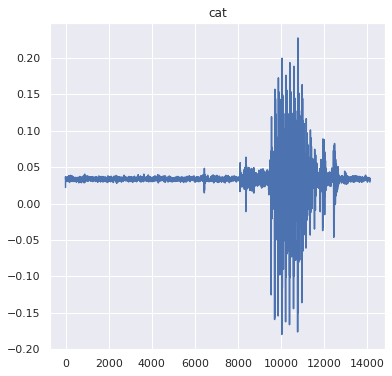

In [40]:
# Get a WAV file for inference and list of labels from the model
tflite_file = os.path.join(SAVE_PATH, TFLITE_FILENAME)
labels = get_labels(tflite_file)
random_audio = get_random_audio_file(test_dir)

# Ensure the audio sample fits the model input
interpreter = tf.lite.Interpreter(tflite_file)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_size = input_details[0]['shape'][1]
sample_rate = get_input_sample_rate(tflite_file)
audio_data, _ = librosa.load(random_audio, sr=sample_rate)
if len(audio_data) < input_size:
  audio_data.resize(input_size)
audio_data = np.expand_dims(audio_data[:input_size], axis=0)

# Run inference
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], audio_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Display prediction and ground truth
top_index = np.argmax(output_data[0])
label = labels[top_index]
score = output_data[0][top_index]
print('---prediction---')
print(f'Class: {label}\nScore: {score}')
print('----truth----')
show_sample(random_audio)

In [41]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(tflite_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>